In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["text.usetex"]=False 

2022-03-16 10:25:57.385340: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [20]:
%matplotlib inline
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>")

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-03-16 10:25:58.945607: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-16 10:25:58.946954: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-16 10:25:58.985514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:41:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-03-16 10:25:58.985567: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-16 10:25:58.990240: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-16 10:25:58.990308: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-0

In [4]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [5]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.4.1


# OmniFold Gaussian Toy Example

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

eff = 0.1 #fraction of true but not reco
fake = 0.1 #fraction of reco but not true

back = 0.1 #fraction of a background process that we would like to subtract

In [7]:
N = 10**5
# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (0.2, 0.8)  # this is the data (the target)
background_param = (0, 1.2)  # background
epsilon = sigma0 / 2.  # Smearing width

dummyval = -10 #a value for examples that don't pass one of the measured/ideal selections

#Synthetic
theta0_G = np.random.normal(theta0_param[0], theta0_param[1],N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G])  # Detector smearing for synthetic sample
pass_reco = np.random.binomial(1,1.-eff,len(theta0_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta0_G)) # what a concise Toy MC with cuts!
theta0_S[pass_reco==0] = dummyval
theta0_G[pass_truth==0] = dummyval

theta0_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta0_S_withback = np.concatenate([theta0_S,theta0_background]) #smeared synthetic (mc_reco)+background
theta0_G_withback = np.concatenate([theta0_G,-np.ones(int(N*back))*dummyval]) #gen synthetic (mc_truth)+background

theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

#Natural
theta_unknown_G = np.random.normal(theta_unknown_param[0],theta_unknown_param[1], N) # Nature, particle-level analog
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta_unknown_G]) # Measured Data analog
pass_reco = np.random.binomial(1,1.-eff,len(theta_unknown_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta_unknown_G))
theta_unknown_S[pass_reco==0] = dummyval
theta_unknown_G[pass_truth==0] = dummyval #emulates cuts done in an analysis

theta_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta_unknown_S_withback = np.concatenate([theta_unknown_S,theta_background]) #Nature+background
theta_unknown_G_withback = np.concatenate([theta_unknown_G,-np.ones(int(N*back))*dummyval]) #Data+Background

theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

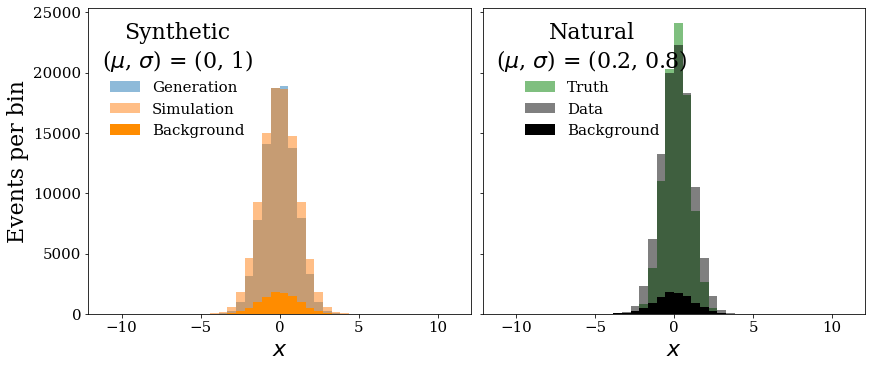

In [8]:
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S_withback[theta0_S_withback!=dummyval], bins=bins, **plot_style_2, label='Simulation')
ax[0].hist(theta0_S_withback[theta0_G_withback==-dummyval], bins=bins, color="darkorange", label='Background')
legend = ax[0].legend(
    title=r'Synthetic''\n''($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel(r'$x$')
ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, **plot_style_2, label='Data',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_G_withback==-dummyval], bins=bins, label='Background',color="black")
legend = ax[1].legend(
    title=r'Natural''\n''($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [9]:
iterations = 4

In [10]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S)) #synthetic, measured.
yvals_1 = np.concatenate((labels0, labels_unknown)) 
#QUESTION: At what point are theses mixed? Avoid [0,0,0...0,1,1...1,1,1]
#I think at test_train_split function

xvals_2 = np.concatenate((theta0_G, theta0_G)) 
#QUESTION whay 0_G twice? Because theta_unknown_G is ultimate target (particle level – nature), 
#and can't be used as an input to the training.
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

2022-03-16 10:26:00.577253: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-16 10:26:00.580639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:41:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-03-16 10:26:00.580688: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-16 10:26:00.580709: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-16 10:26:00.580721: I tensorflow/stream_executor/platform/def

In [11]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights)) 
#Question: how is the model passed? Stored in memory before function is called?
#QUESTION: is this p(w,X)/p(w',X'), where p is PDF of (x)?
#reweights sim to data, then 

In [12]:
#We can do the background subtraction as part of the iterative unfolding, but it is easier to do it first.

    
x_data_and_MCback = np.concatenate([theta0_S_withback[theta0_G_withback==-dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]])
    
y_data_and_MCback = np.concatenate([np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.zeros(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])
    
W_data_and_MCback = np.concatenate([-1.*np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
    x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)

    
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=200,
          batch_size=10000,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=1)

2022-03-16 10:26:14.044802: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-16 10:26:14.045261: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2994530000 Hz


Epoch 1/200
 1/16 [>.............................] - ETA: 7s - loss: 0.6256 - accuracy: 0.4747

2022-03-16 10:26:14.372623: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


16/16 [==============================] - 5s 307ms/step - loss: 0.6254 - accuracy: 0.4752 - val_loss: 0.6275 - val_accuracy: 0.4786
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6231 - accuracy: 0.4742 - val_loss: 0.6274 - val_accuracy: 0.4786
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.4745 - val_loss: 0.6274 - val_accuracy: 0.4786
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6249 - accuracy: 0.4749 - val_loss: 0.6274 - val_accuracy: 0.4786
Epoch 5/200
16/16 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.4765 - val_loss: 0.6274 - val_accuracy: 0.4786
Epoch 6/200
16/16 [==============================] - 0s 3ms/step - loss: 0.6242 - accuracy: 0.4756 - val_loss: 0.6274 - val_accuracy: 0.4786
Epoch 7/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.4745 - val_loss: 0.6274 - val_accuracy: 0.4786
Epoch 8/200
16/16 [====

In [13]:
w_data = reweight(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])

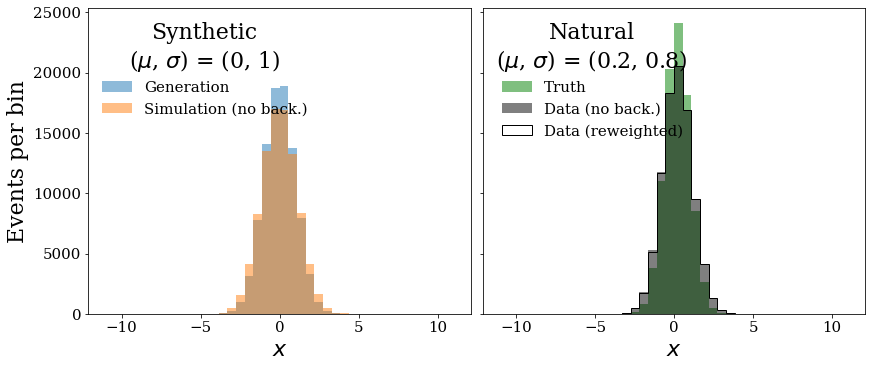

In [14]:
i=0
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S!=dummyval], bins=bins, **plot_style_2, label='Simulation (no back.)')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S[theta_unknown_S!=dummyval], bins=bins, **plot_style_2, label='Data (no back.)',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, histtype="step", label='Data (reweighted)',color="black",weights=w_data)
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()
plt.savefig("plot_"+str(i)+"_datareweight.pdf")

In [15]:
# initial iterative weights are ones
weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

In [16]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))
yvals_1 = np.concatenate((labels0, np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))))

In [17]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, w_data))
    #QUESTION: concatenation here confuses me
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1) #REMINDER: made up of synthetic+measured

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1[X_train_1!=dummyval],
              Y_train_1[X_train_1!=dummyval],
              sample_weight=w_train_1[X_train_1!=dummyval],
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1[X_test_1!=dummyval], Y_test_1[X_test_1!=dummyval], w_test_1[X_test_1!=dummyval]),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(theta0_S) 
    #QUESTION: above model used in reweight function (model.predict)?
    #QUESTION: Model trains until synthetic is indistinguishable from data? How does this work? 
    #How are weights then iteratively multiplied?
    
    ###
    #Need to do something with events that don't pass reco.
    
    #One option is to take the prior:
    #weights_pull[theta0_S==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_true>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_G[theta0_S!=dummyval],theta0_G[theta0_S!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_G[theta0_S!=dummyval])),np.zeros(len(theta0_G[theta0_S!=dummyval]))])
    weights_1b = np.concatenate([weights_pull[theta0_S!=dummyval],np.ones(len(theta0_G[theta0_S!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)
    
    average_vals = reweight(theta0_G[theta0_S==dummyval])
    weights_pull[theta0_S==dummyval] = average_vals
    ###
    
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=2000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    weights_push = reweight(theta0_G)
    ###
    #Need to do something with events that don't pass truth    
    
    #One option is to take the prior:
    #weights_push[theta0_G==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_reco>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_S[theta0_G!=dummyval],theta0_S[theta0_G!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_S[theta0_G!=dummyval])),np.zeros(len(theta0_S[theta0_G!=dummyval]))])
    weights_1b = np.concatenate([weights_push[theta0_G!=dummyval],np.ones(len(theta0_S[theta0_G!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)
    
    average_vals = reweight(theta0_S[theta0_G==dummyval])
    weights_push[theta0_G==dummyval] = average_vals
    ###    
    
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Epoch 1/200
15/15 [==============================] - 4s 278ms/step - loss: 0.6527 - accuracy: 0.4980 - val_loss: 0.6494 - val_accuracy: 0.5442
Epoch 2/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6489 - accuracy: 0.5504 - val_loss: 0.6480 - val_accuracy: 0.5528
Epoch 3/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6477 - accuracy: 0.5538 - val_loss: 0.6474 - val_accuracy: 0.5546
Epoch 4/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6469 - accuracy: 0.5596 - val_loss: 0.6472 - val_accuracy: 0.5551
Epoch 5/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6471 - accuracy: 0.5578 - val_loss: 0.6472 - val_accuracy: 0.5557
Epoch 6/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.5582 - val_loss: 0.6472 - val_accuracy: 0.5558
Epoch 7/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6464 - accuracy: 0.5601 - val_loss: 0.6471 - val_accur

14/14 [==============================] - 0s 7ms/step - loss: 0.6889 - accuracy: 0.5005 - val_loss: 0.6881 - val_accuracy: 0.4965
Epoch 34/200
14/14 [==============================] - 0s 6ms/step - loss: 0.6890 - accuracy: 0.5017 - val_loss: 0.6881 - val_accuracy: 0.4951
Epoch 35/200
14/14 [==============================] - 0s 5ms/step - loss: 0.6884 - accuracy: 0.5014 - val_loss: 0.6878 - val_accuracy: 0.4957
Epoch 36/200
14/14 [==============================] - 0s 5ms/step - loss: 0.6883 - accuracy: 0.5007 - val_loss: 0.6877 - val_accuracy: 0.4960
Epoch 37/200
14/14 [==============================] - 0s 5ms/step - loss: 0.6888 - accuracy: 0.5018 - val_loss: 0.6878 - val_accuracy: 0.4958
Epoch 38/200
14/14 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.5004 - val_loss: 0.6877 - val_accuracy: 0.4966
Epoch 39/200
14/14 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.5031 - val_loss: 0.6876 - val_accuracy: 0.4955
Restoring model wei

Epoch 7/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6600 - accuracy: 0.5455 - val_loss: 0.6611 - val_accuracy: 0.5559
Epoch 8/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6601 - accuracy: 0.5516 - val_loss: 0.6609 - val_accuracy: 0.5472
Epoch 9/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6604 - accuracy: 0.5522 - val_loss: 0.6609 - val_accuracy: 0.5556
Epoch 10/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6601 - accuracy: 0.5492 - val_loss: 0.6610 - val_accuracy: 0.5541
Epoch 11/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6597 - accuracy: 0.5494 - val_loss: 0.6611 - val_accuracy: 0.5561
Epoch 12/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6605 - accuracy: 0.5543 - val_loss: 0.6609 - val_accuracy: 0.5531
Epoch 13/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6605 - accuracy: 0.5489 - val_loss: 0.6610 - val_accuracy: 0.5551
Restoring

75/75 [==============================] - 0s 2ms/step - loss: 0.6812 - accuracy: 0.4988 - val_loss: 0.6813 - val_accuracy: 0.5005
Epoch 29/200
75/75 [==============================] - 0s 2ms/step - loss: 0.6812 - accuracy: 0.4982 - val_loss: 0.6814 - val_accuracy: 0.5005
Epoch 30/200
75/75 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.4978 - val_loss: 0.6815 - val_accuracy: 0.5000
Epoch 31/200
75/75 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.4987 - val_loss: 0.6814 - val_accuracy: 0.4997
Epoch 32/200
75/75 [==============================] - 0s 2ms/step - loss: 0.6807 - accuracy: 0.4992 - val_loss: 0.6814 - val_accuracy: 0.4997
Epoch 33/200
75/75 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.4971 - val_loss: 0.6814 - val_accuracy: 0.4999
Epoch 34/200
75/75 [==============================] - 0s 2ms/step - loss: 0.6809 - accuracy: 0.5009 - val_loss: 0.6814 - val_accuracy: 0.5000
Epoch 35/200
75/75 

Epoch 10/200
14/14 [==============================] - 0s 5ms/step - loss: 0.6822 - accuracy: 0.5007 - val_loss: 0.6830 - val_accuracy: 0.4993
Epoch 11/200
14/14 [==============================] - 0s 5ms/step - loss: 0.6829 - accuracy: 0.4999 - val_loss: 0.6830 - val_accuracy: 0.5002
Epoch 12/200
14/14 [==============================] - 0s 5ms/step - loss: 0.6819 - accuracy: 0.5005 - val_loss: 0.6830 - val_accuracy: 0.4992
Epoch 13/200
14/14 [==============================] - 0s 5ms/step - loss: 0.6824 - accuracy: 0.4988 - val_loss: 0.6830 - val_accuracy: 0.4997
Epoch 14/200
14/14 [==============================] - 0s 5ms/step - loss: 0.6823 - accuracy: 0.4998 - val_loss: 0.6829 - val_accuracy: 0.4999
Epoch 15/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.5012 - val_loss: 0.6831 - val_accuracy: 0.4992
Epoch 16/200
14/14 [==============================] - 0s 6ms/step - loss: 0.6822 - accuracy: 0.5003 - val_loss: 0.6830 - val_accuracy: 0.4993
Epoch 

Epoch 21/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6604 - accuracy: 0.5263 - val_loss: 0.6614 - val_accuracy: 0.5450
Epoch 22/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6602 - accuracy: 0.5440 - val_loss: 0.6613 - val_accuracy: 0.5301
Epoch 23/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6604 - accuracy: 0.5377 - val_loss: 0.6614 - val_accuracy: 0.5345
Epoch 24/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6607 - accuracy: 0.5360 - val_loss: 0.6613 - val_accuracy: 0.5290
Epoch 25/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6606 - accuracy: 0.5272 - val_loss: 0.6614 - val_accuracy: 0.5343
Epoch 26/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6609 - accuracy: 0.5335 - val_loss: 0.6613 - val_accuracy: 0.5304
Epoch 27/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6606 - accuracy: 0.5307 - val_loss: 0.6614 - val_accuracy: 0.5308
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 0.6804 - accuracy: 0.5004 - val_loss: 0.6803 - val_accuracy: 0.4988
Epoch 13/200
14/14 [==============================] - 0s 6ms/step - loss: 0.6808 - accuracy: 0.4998 - val_loss: 0.6803 - val_accuracy: 0.4984
Epoch 14/200
14/14 [==============================] - 0s 6ms/step - loss: 0.6806 - accuracy: 0.5019 - val_loss: 0.6803 - val_accuracy: 0.5006
Epoch 15/200
14/14 [==============================] - 0s 5ms/step - loss: 0.6806 - accuracy: 0.5003 - val_loss: 0.6803 - val_accuracy: 0.4989
Epoch 16/200
14/14 [==============================] - 0s 5ms/step - loss: 0.6801 - accuracy: 0.5026 - val_loss: 0.6803 - val_accuracy: 0.4997
Epoch 17/200
14/14 [==============================] - 0s 7ms/step - loss: 0.6806 - accuracy: 0.5011 - val_loss: 0.6803 - val_accuracy: 0.4990
Epoch 18/200
14/14 [==============================] - 0s 5ms/step - loss: 0.6808 - accuracy: 0.4980 - val_loss: 0.6803 - val_accuracy: 0.4985
Epoch 19/200
14/14 

ITERATION 1:
ITERATION 2:
ITERATION 3:
ITERATION 4:


<Figure size 864x360 with 0 Axes>

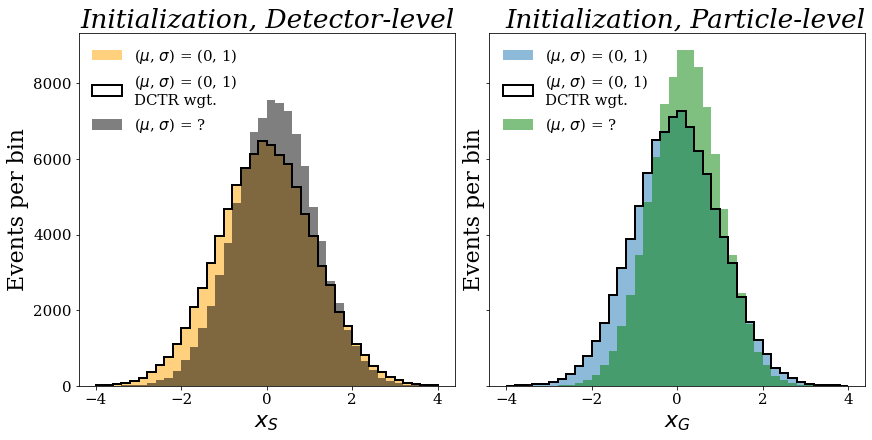

<Figure size 864x360 with 0 Axes>

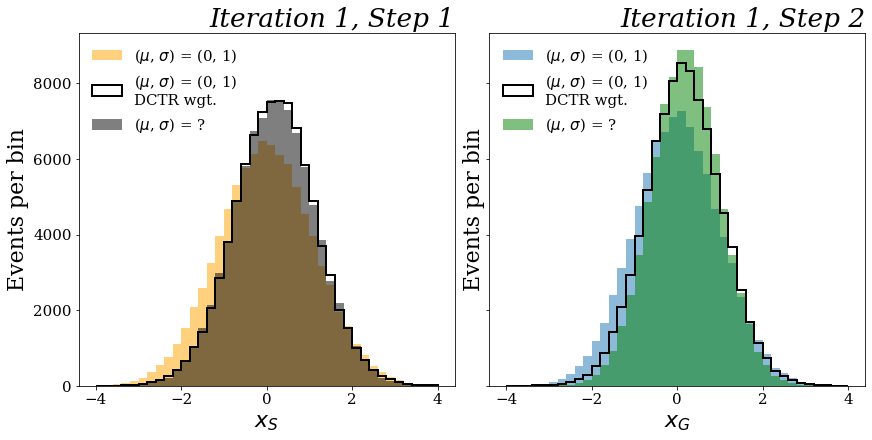

<Figure size 864x360 with 0 Axes>

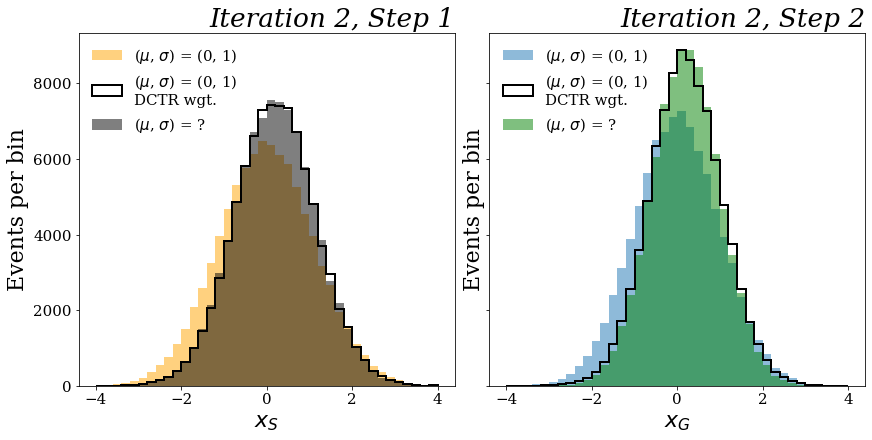

<Figure size 864x360 with 0 Axes>

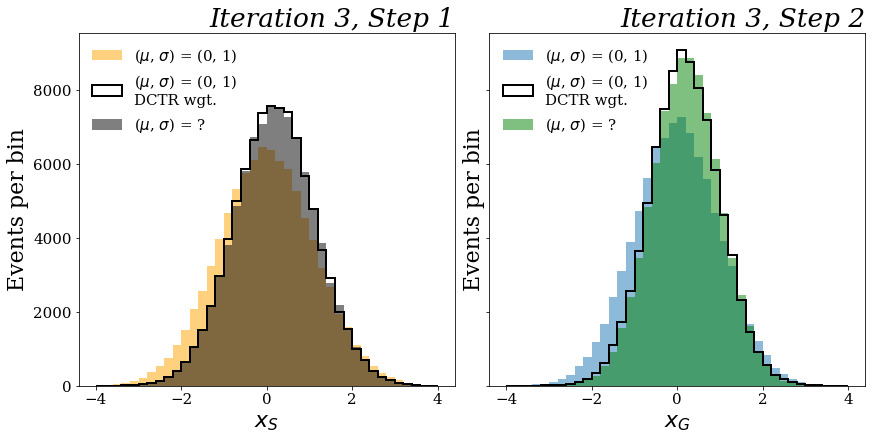

<Figure size 864x360 with 0 Axes>

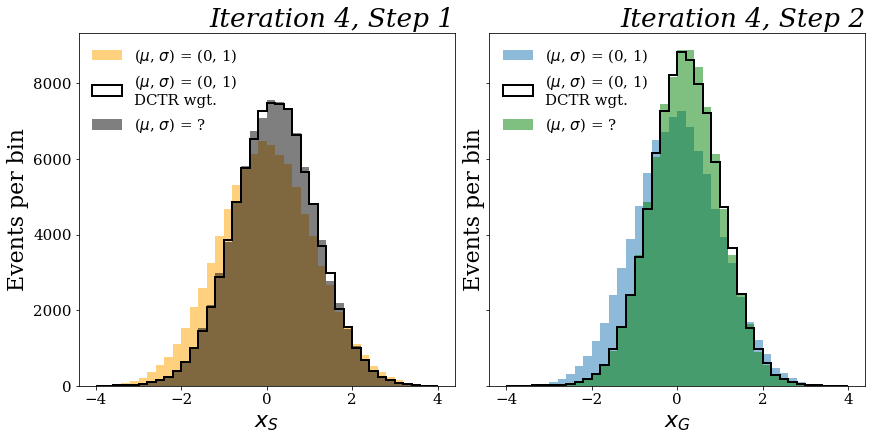

In [18]:
bins = np.linspace(-4, 4, 41)

plt.figure(figsize=(12, 5))

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

#Detector-level
ax[0].set_title("Initialization, Detector-level",style='italic',loc='right')
hist0 = ax[0].hist(theta0_S[theta0_S!=dummyval],
                 bins=bins,
                 color="orange",
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[0].hist(
    theta0_S[theta0_S!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 weights=weights[i, 0, :][theta_unknown_S!=dummyval],
                 **plot_style_2,
                color="black")
ax[0].legend(frameon=False)
ax[0].set_xlabel(r"$x_S$")
ax[0].set_ylabel("Events per bin")

#Particle-level
ax[1].set_title("Initialization, Particle-level",style='italic',loc='right')
_,_,_=ax[1].hist(theta0_G[theta0_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[1].hist(
    theta0_G[theta0_G!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 **plot_style_2,
                color="green")
ax[1].legend(frameon=False)
ax[1].set_xlabel(r"$x_G$")
ax[1].set_ylabel("Events per bin")

plt.savefig("plot_0.pdf")

#Iterations
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(12, 5))
    
    fig, ax = plt.subplots(1,2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
    
    #Detector-level
    ax[0].set_title("Iteration " +str(i+1)+ ", Step 1",style='italic',loc='right')
    _,_,_ = ax[0].hist(theta0_S[theta0_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     color="orange",
                     **plot_style_2)

    _,_,_ = ax[0].hist(
        theta0_S[theta0_S!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 0, :][theta0_S!=dummyval],
        **plot_style_1)
    _,_,_ = ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="black")
    ax[0].legend(frameon=False)
    ax[0].set_xlabel(r"$x_S$")
    ax[0].set_ylabel("Events per bin")
    
    #Particle-level
    ax[1].set_title("Iteration " +str(i+1)+ ", Step 2",style='italic',loc='right')
    _,_,_ = ax[1].hist(theta0_G[theta0_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    _,_,_ = ax[1].hist(
        theta0_G[theta0_G!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :][theta0_G!=dummyval],
        **plot_style_1)
    _,_,_ = ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="green")
    ax[1].legend(frameon=False)
    ax[1].set_xlabel(r"$x_G$")
    ax[1].set_ylabel("Events per bin")
    
    plt.savefig("plot_"+str(i+1)+".pdf")